# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [4]:
from sklearn.datasets import make_moons, make_circles
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

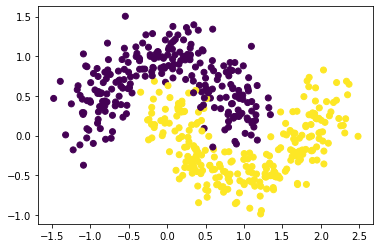

In [5]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

In [6]:
moons_points_test, moons_labels_test = make_moons(n_samples=500, noise=0.2, random_state=24)
circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=24)
points_test = np.vstack((circles_points*2.5 + 0.5, moons_points_test)) # на будущее
labels_test = np.hstack((circles_labels, moons_labels_test + 2)) # + 2 to distinct moons classes

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [11]:
!pip install mlxtend

  Using cached mlxtend-0.22.0-py2.py3-none-any.whl (1.4 MB)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from mlxtend.plotting import plot_decision_regions

# lr = LogisticRegression() # add some params
# svm = SVC(kernel='linear') # here too

# ### YOUR CODE HERE

f1 score: 0.8699869986998701


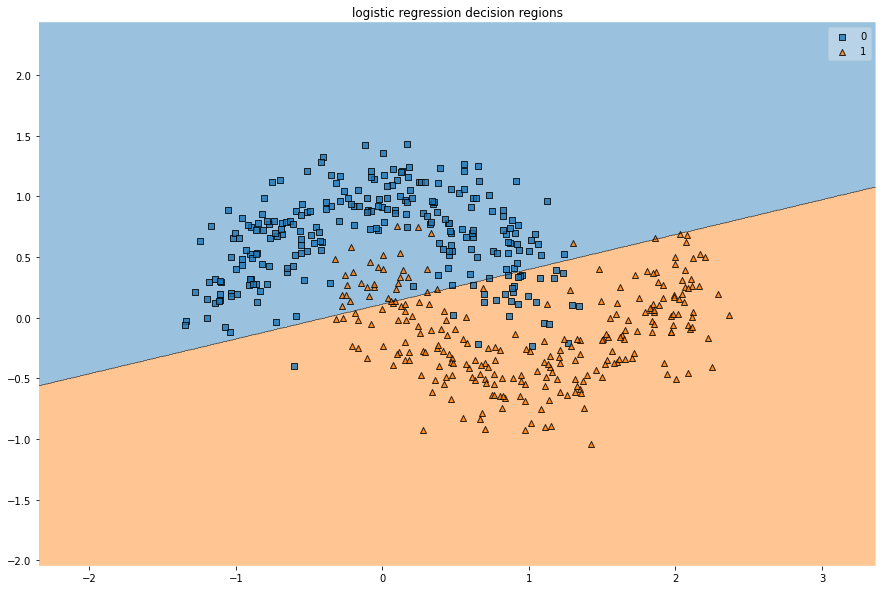

In [13]:
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42, solver='saga', tol=0.001,).fit(moons_points, moons_labels)

plt.figure(figsize=(15, 10))
plt.title("logistic regression decision regions")
plot_decision_regions(moons_points_test, moons_labels_test, clf=clf)

print(f"f1 score: {f1_score(moons_labels_test, clf.predict(moons_points_test), average='weighted')}")

f1 score: 0.863921618852459


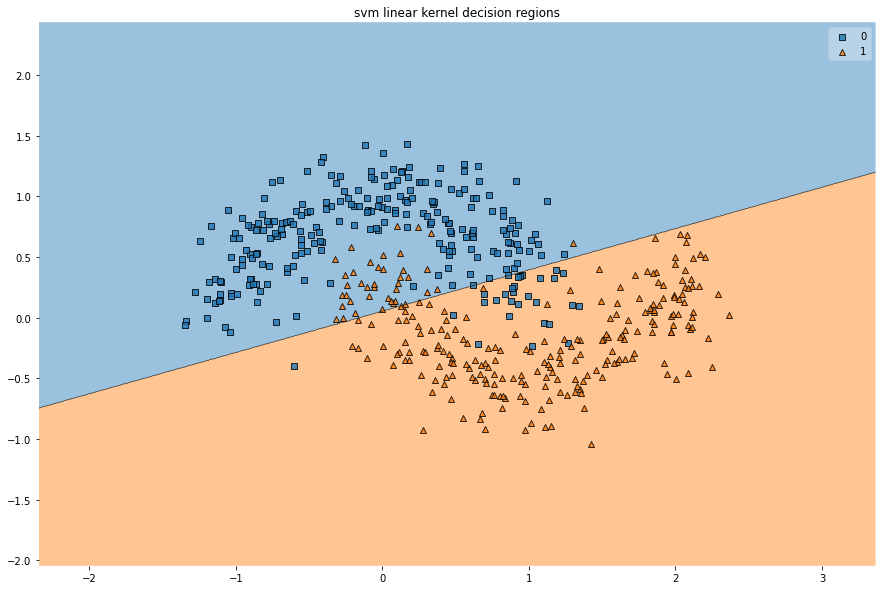

In [14]:
clf = SVC(C=0.75, kernel='linear').fit(moons_points, moons_labels)

plt.figure(figsize=(15, 10))
plt.title("svm linear kernel decision regions")
plot_decision_regions(moons_points_test, moons_labels_test, clf=clf)
print(f"f1 score: {f1_score(moons_labels_test, clf.predict(moons_points_test), average='weighted')}")

Разницы в скорах и графика не вижу, но svm обучается дольше. 

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

In [15]:
def fit_plot_decision_regions(kernel, X=moons_points, y=moons_labels, X_test=moons_points_test, y_test=moons_labels_test, C=0.75, degree=3):
    clf = SVC(C=C, degree=degree, kernel=kernel).fit(X, y)
    f1  = f1_score(moons_labels_test, clf.predict(moons_points_test), average='weighted')
    plt.figure(figsize=(15, 10))
    plt.title(f"svm {kernel} kernel decision regions, C={C}, degree={degree} | f1: {f1}") # degree ignored if kernel != poly
    plot_decision_regions(moons_points_test, moons_labels_test, clf=clf)

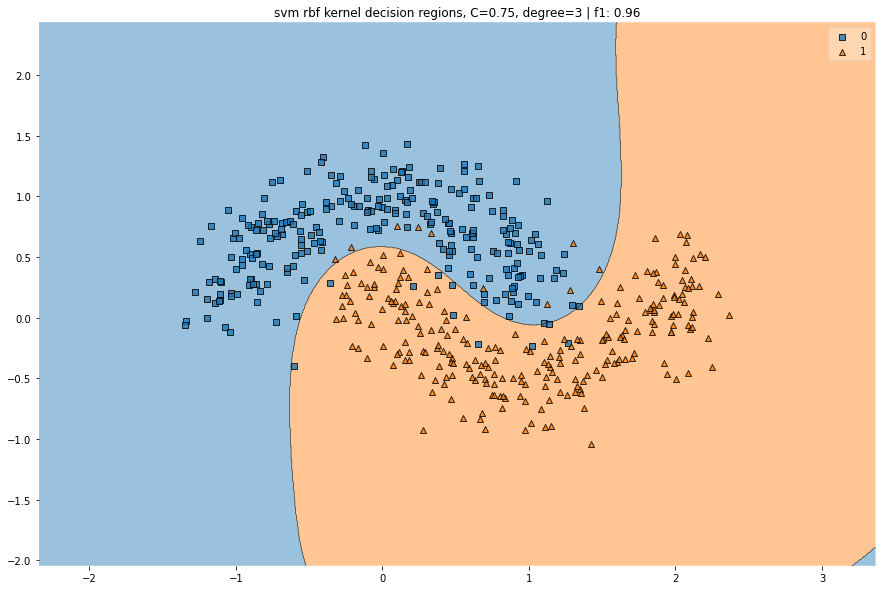

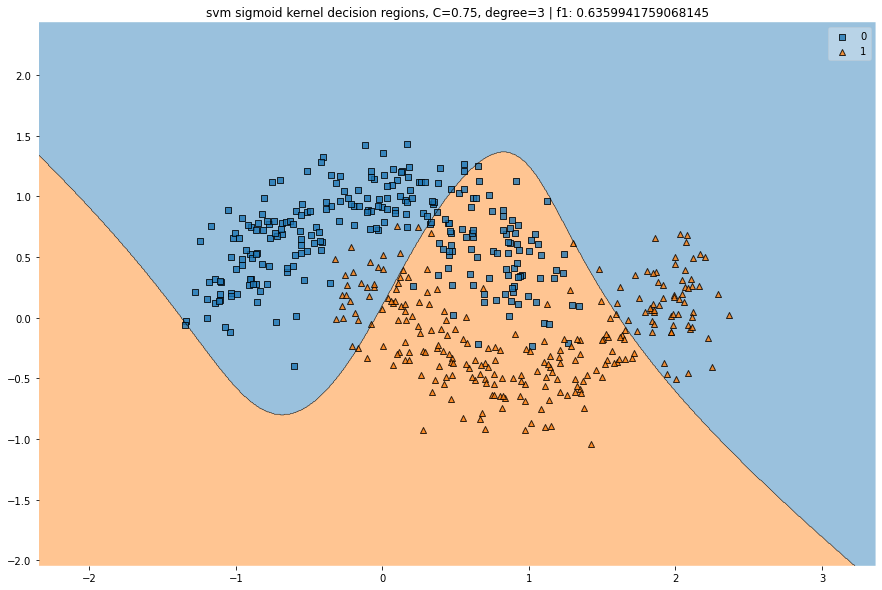

In [16]:
fit_plot_decision_regions('rbf')
fit_plot_decision_regions('sigmoid')

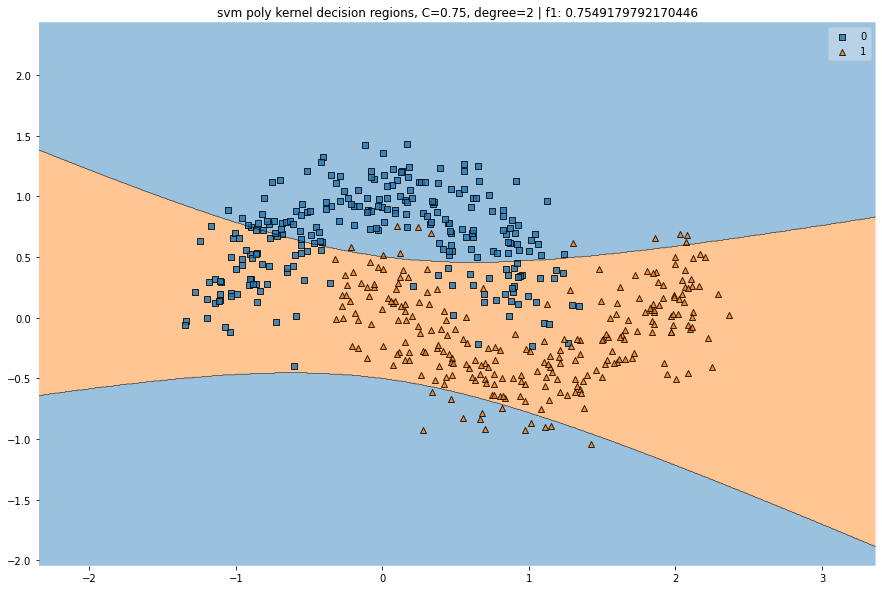

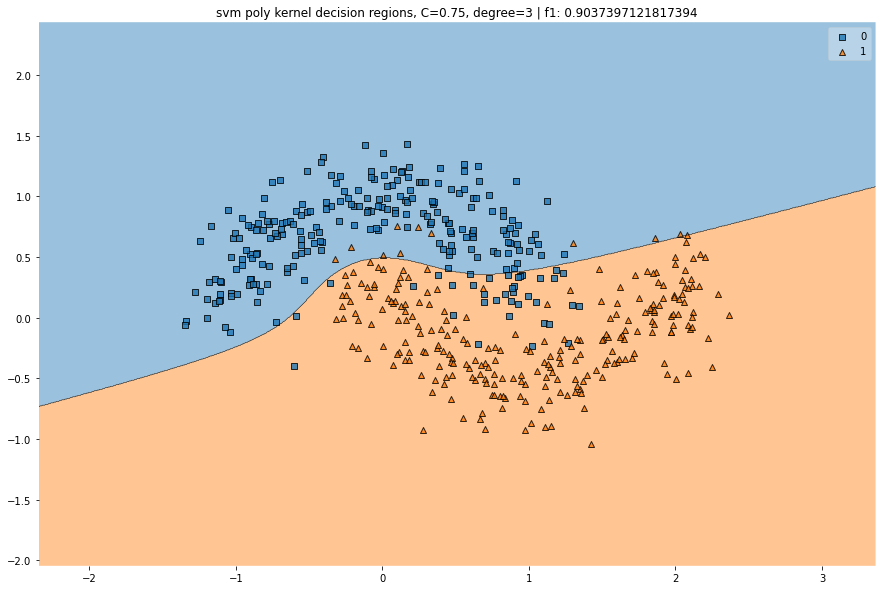

In [17]:
fit_plot_decision_regions('poly', degree=2)
fit_plot_decision_regions('poly', degree=3)

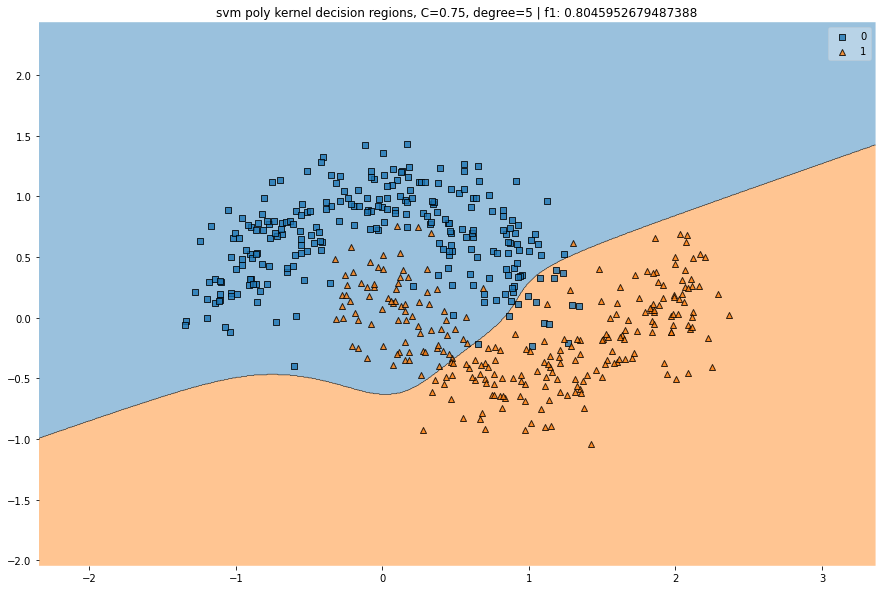

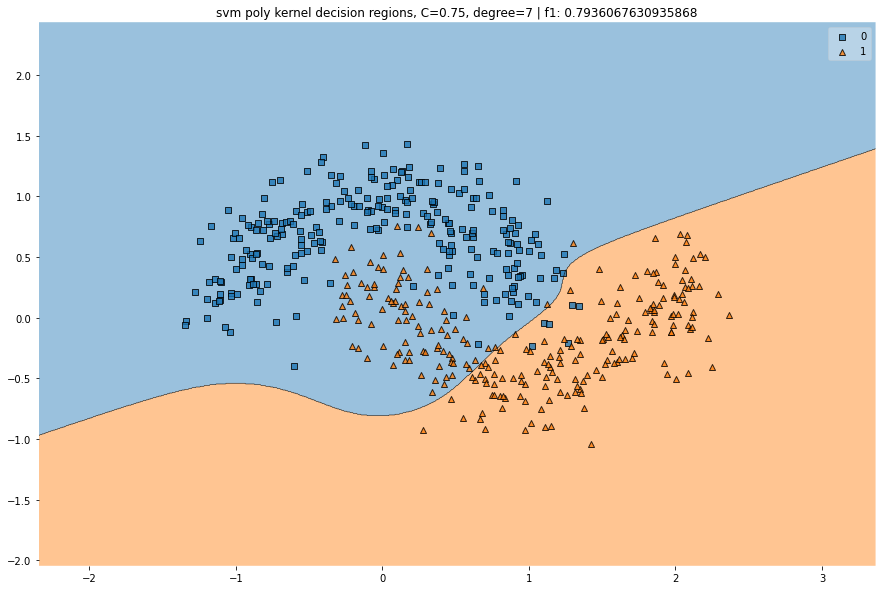

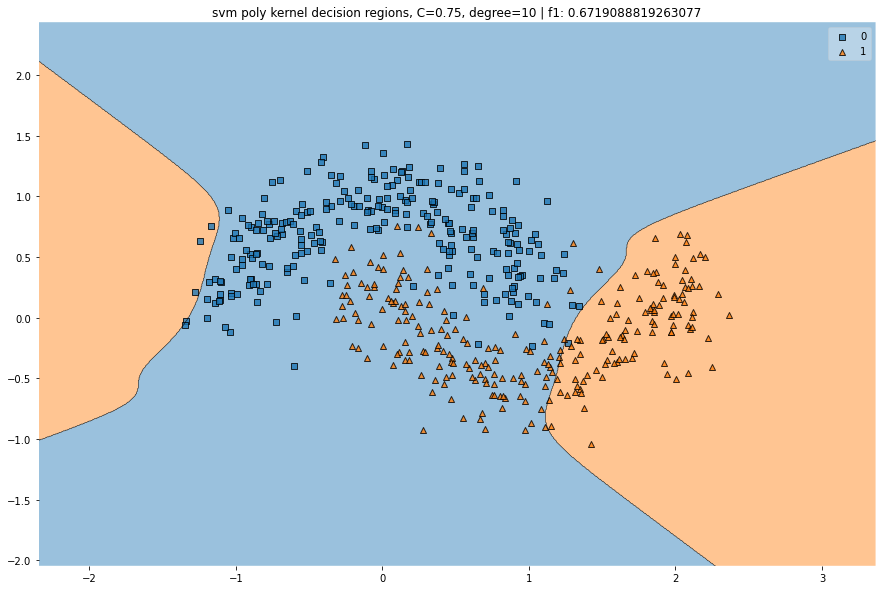

In [18]:
fit_plot_decision_regions('poly', degree=5)
fit_plot_decision_regions('poly', degree=7)
fit_plot_decision_regions('poly', degree=10)

Идеально сработал rbf, чуть хуже poly с degree = 3. Полиномиальная с большим degree почему-то стремится правильно классифицировать синие объекты, из-за этого скор драматически снижается. Я ожидал наоборот переобучения под выборку (как сказано в разделе про practical use: https://en.wikipedia.org/wiki/Polynomial_kernel#:~:text=In%20machine%20learning%2C%20the%20polynomial,learning%20of%20non%2Dlinear%20models) т.к. разделяющая функция при росте степени многочлена теоретически может иметь больше вариаций и разбросов (короче, степень свободы больше).

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [19]:
from sklearn.preprocessing import PolynomialFeatures

for i in [2, 3, 5, 7, 10]:
  poly = PolynomialFeatures(i)
  moons_points_poly = poly.fit_transform(moons_points)
  clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42, solver='saga', tol=0.001,).fit(moons_points_poly, moons_labels)
  moons_points_test_poly = poly.transform(moons_points_test)
  print(f"n_poly_features={i}, f1 score: {f1_score(moons_labels_test, clf.predict(moons_points_test_poly), average='weighted')}")

n_poly_features=2, f1 score: 0.8699745150049409
n_poly_features=3, f1 score: 0.9519992319877119
n_poly_features=5, f1 score: 0.9399990399846397
n_poly_features=7, f1 score: 0.8329094940010434
n_poly_features=10, f1 score: 0.6998799519807923


Снова та же закономерность - чем больше уходим за n_poly_features=3, тем хуже скор. Это точно не переобучение, т.к. валидируемся на тренировочной выборке. 

Меня это заинтриговало и так как я не очень шарю, то вышел в сеть Интернет с этим вопросом, вот что нашел: https://datascience.stackexchange.com/questions/46052/why-is-my-training-accuracy-decreasing-higher-degrees-of-polynomial-features

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

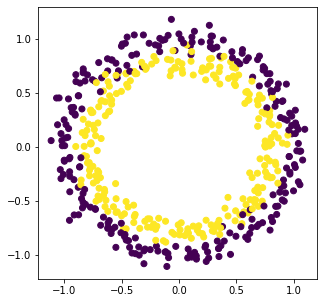

In [20]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

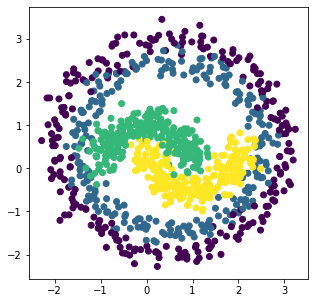

In [21]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

Возьмем SVM с kernel=rbf, эта модель хорошо себя показала.

In [22]:
def fit_plot_decision_regions(kernel, X=points, y=labels, X_test=points_test, y_test=labels_test, C=0.75, degree=3):
    clf = SVC(C=C, degree=degree, kernel=kernel).fit(X, y)
    f1  = f1_score(y_test, clf.predict(X_test), average='weighted')
    plt.figure(figsize=(15, 10))
    plt.title(f"svm {kernel} kernel decision regions, C={C}, degree={degree} | f1: {f1}") # degree ignored if kernel != poly
    plot_decision_regions(X_test, y_test, clf=clf)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\mlxtend\plotting\decision_regions.py:352: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  **scatter_kwargs


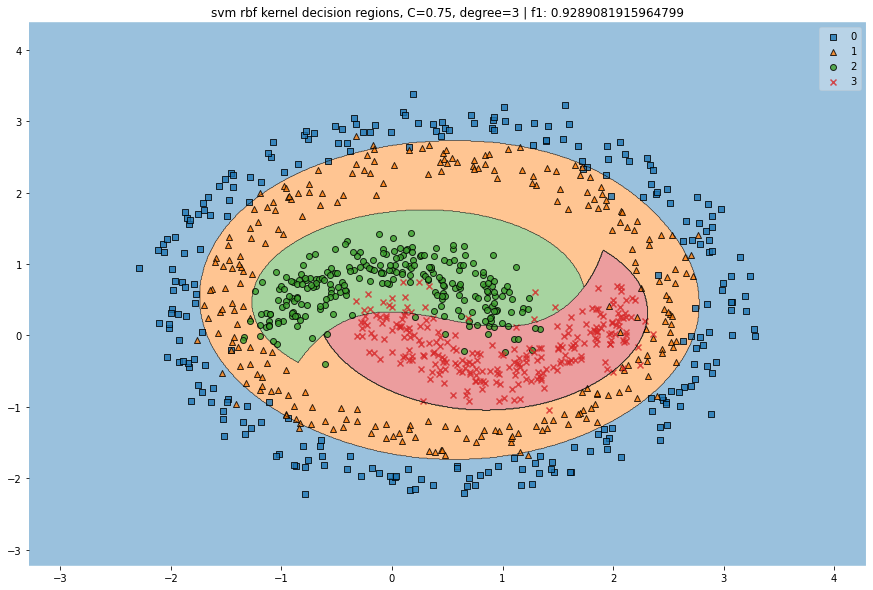

In [23]:
fit_plot_decision_regions(kernel='rbf')

In [28]:
def plot_me_decision_regions(clf, X, y):
    f1  = f1_score(y, clf.predict(X), average='weighted')
    plt.figure(figsize=(15, 10))
    plt.title(f"some model decision regions | f1: {f1}")
    plot_decision_regions(X, y, clf=clf)